Pull data from snotel data base and analyze time series to see if there are any discernable trends. Output results to HTML so that it could be easily loaded in a website.

In [1]:
import pandas as pd
import csv
import requests
import os

In [5]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\snotel\analysis'
os.chdir(path)

In [6]:
# function to clean the inputs for the database
def clean_up(num):
    try:
        return float(num)
    except:
        return 0

In [76]:
# Pull the data just for the first snotel site on the list
url='https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/842:CO:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/SNWD::value,WTEQ::value,SNWD::delta?fitToScreen=false'
response = requests.get(url)

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    for line in response.text.splitlines():
        if "#" not in line:
            fo.write(line + '\n')

In [77]:
# read result back in as PD
snow = pd.read_csv(clean_file, error_bad_lines=False)
snow

,Date,Vail Mountain (842) Snow Depth (in) Start of Day Values,Vail Mountain (842) Snow Water Equivalent (in) Start of Day Values,Vail Mountain (842) Change In Snow Depth (in) Start of Day Values
0,1978-10-01,NaN,0.0,NaN
1,1978-10-02,NaN,0.0,NaN
2,1978-10-03,NaN,0.0,NaN
3,1978-10-04,NaN,0.0,NaN
4,1978-10-05,NaN,0.0,NaN
...,...,...,...,...
15723,2021-10-18,0.0,0.2,-1.0
15724,2021-10-19,1.0,0.2,1.0
15725,2021-10-20,NaN,0.2,NaN
15726,2021-10-21,0.0,0.2,NaN


That's what we want. Now we just need to eliminate the NaN values: fill the first row with 0 and then use the previous value to fill all the other Nan.

In [78]:
snow.loc[0]

Date                                                                  1978-10-01
Vail Mountain (842) Snow Depth (in) Start of Day Values                      NaN
Vail Mountain (842) Snow Water Equivalent (in) Start of Day Values             0
Vail Mountain (842) Change In Snow Depth (in) Start of Day Values            NaN
Name: 0, dtype: object

In [79]:
# rename columns
snow.columns = ['ds', 'Depth', 'Water', 'y']

In [80]:
snow.fillna(value=0, inplace=True)

In [81]:
snow

,ds,Depth,Water,y
0,1978-10-01,0.0,0.0,0.0
1,1978-10-02,0.0,0.0,0.0
2,1978-10-03,0.0,0.0,0.0
3,1978-10-04,0.0,0.0,0.0
4,1978-10-05,0.0,0.0,0.0
...,...,...,...,...
15723,2021-10-18,0.0,0.2,-1.0
15724,2021-10-19,1.0,0.2,1.0
15725,2021-10-20,0.0,0.2,0.0
15726,2021-10-21,0.0,0.2,0.0


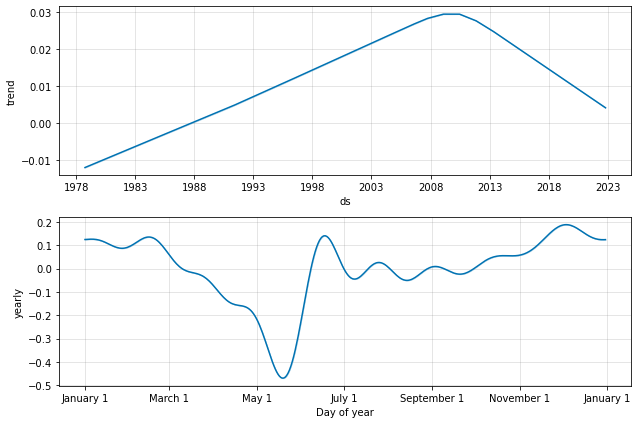

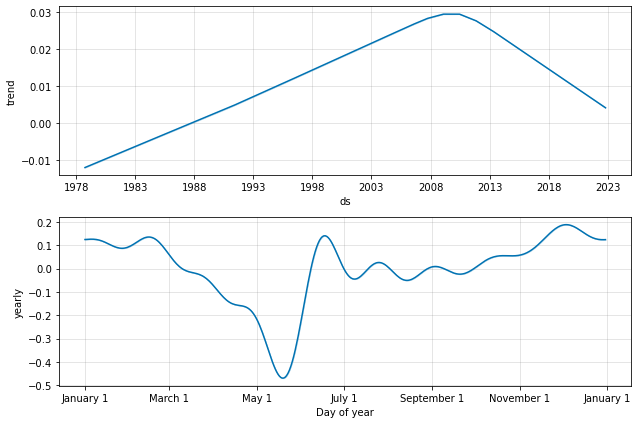

In [82]:
# let's take a better look at this with FB's Prophet - not considering any other regressors yet
from fbprophet import Prophet
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

That looks OK, but I want more consistent values. I think the loss of snow may also be hurting the values. I will remove the negative values and do a 7-day sum.

In [83]:
# let's set the new "y" column to not have snowfall that is less than 0 and see how that effects the analysis
snow.rename(columns={'y':'new'}, inplace=True)

In [84]:
snow['new']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15723   -1.0
15724    1.0
15725    0.0
15726    0.0
15727    0.0
Name: new, Length: 15728, dtype: float64

In [85]:
snow['acc'] = [v if v >= 0 else 0 for v in snow['new']]
# [snow['new'] if snow['new'] >= 0 else 0]

In [86]:
snow

,ds,Depth,Water,new,acc
0,1978-10-01,0.0,0.0,0.0,0.0
1,1978-10-02,0.0,0.0,0.0,0.0
2,1978-10-03,0.0,0.0,0.0,0.0
3,1978-10-04,0.0,0.0,0.0,0.0
4,1978-10-05,0.0,0.0,0.0,0.0
...,...,...,...,...,...
15723,2021-10-18,0.0,0.2,-1.0,0.0
15724,2021-10-19,1.0,0.2,1.0,1.0
15725,2021-10-20,0.0,0.2,0.0,0.0
15726,2021-10-21,0.0,0.2,0.0,0.0


In [87]:
# checking myself to make sure they are all positive
snow['acc'].value_counts()

0.0      14742
1.0        339
2.0        218
3.0        147
4.0         98
5.0         62
6.0         27
7.0         25
8.0         16
9.0         13
10.0         5
12.0         5
136.0        3
15.0         2
198.0        2
133.0        2
16.0         1
185.0        1
132.0        1
182.0        1
134.0        1
156.0        1
194.0        1
138.0        1
184.0        1
135.0        1
159.0        1
166.0        1
141.0        1
169.0        1
102.0        1
11.0         1
144.0        1
19.0         1
13.0         1
170.0        1
165.0        1
125.0        1
Name: acc, dtype: int64

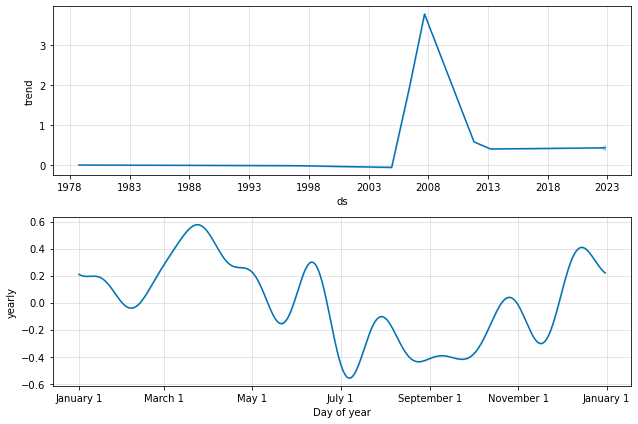

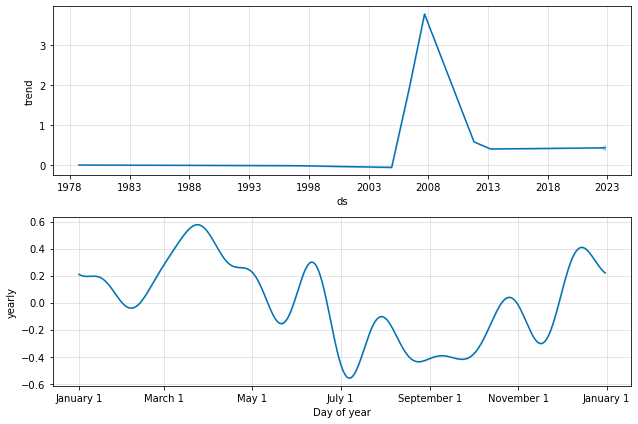

In [88]:
# let's rename and run the analysis again
snow.rename(columns={'acc':'y'}, inplace=True)
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

Those look so much better! Let's try it with a 7-day accumulation.

In [89]:
snow["acc7"] = snow.rolling(window=7)['y'].sum()

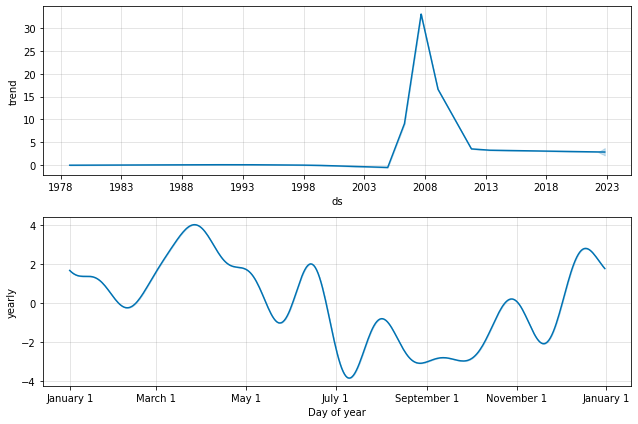

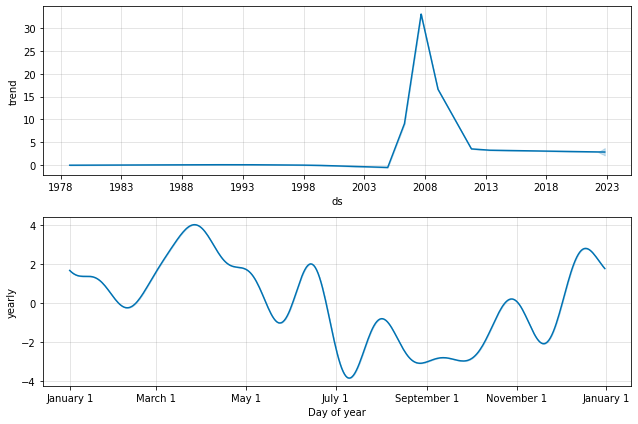

In [90]:
snow.rename(columns={'y':'acc', 'acc7':'y'}, inplace=True)
m_fb = Prophet(yearly_seasonality = True, daily_seasonality=False, weekly_seasonality=False)
m_fb.fit(snow)
future = m_fb.make_future_dataframe(periods=365)
forecast = m_fb.predict(future)
m_fb.plot_components(forecast)

In [91]:
# let's calculate some stats about the snowfall at this site
snow["acc365"] = snow.rolling(window=365)['acc'].sum()
snow

,ds,Depth,Water,new,acc,y,acc365
0,1978-10-01,0.0,0.0,0.0,0.0,NaN,NaN
1,1978-10-02,0.0,0.0,0.0,0.0,NaN,NaN
2,1978-10-03,0.0,0.0,0.0,0.0,NaN,NaN
3,1978-10-04,0.0,0.0,0.0,0.0,NaN,NaN
4,1978-10-05,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
15723,2021-10-18,0.0,0.2,-1.0,0.0,1.0,123.0
15724,2021-10-19,1.0,0.2,1.0,1.0,2.0,124.0
15725,2021-10-20,0.0,0.2,0.0,0.0,1.0,124.0
15726,2021-10-21,0.0,0.2,0.0,0.0,1.0,124.0


In [92]:
annual = snow[snow['ds'].str.contains("-10-01")]
annual

,ds,Depth,Water,new,acc,y,acc365
0,1978-10-01,0.0,0.0,0.0,0.0,NaN,NaN
365,1979-10-01,0.0,0.0,0.0,0.0,0.0,0.0
731,1980-10-01,0.0,0.0,0.0,0.0,0.0,0.0
1096,1981-10-01,0.0,0.0,0.0,0.0,0.0,0.0
1461,1982-10-01,0.0,0.0,0.0,0.0,0.0,0.0
1826,1983-10-01,0.0,0.0,0.0,0.0,0.0,0.0
2192,1984-10-01,0.0,0.0,0.0,0.0,0.0,0.0
2557,1985-10-01,0.0,0.5,0.0,0.0,0.0,0.0
2922,1986-10-01,0.0,0.9,0.0,0.0,0.0,0.0
3287,1987-10-01,0.0,0.0,0.0,0.0,0.0,0.0


This show a real potential issue: not all of the snow years actually have snowfall recorded, so we probably should have thrown those years out before we did the analysis. <br>
I will think about how to automate this process.

In [71]:
# we delete all rows before accumulations has a measureable value
snow[5113:]

,ds,Depth,Water,new,acc,y,acc365
5113,1998-10-01,0.0,0.0,0.0,0.0,0.0,0.0
5114,1998-10-02,0.0,0.0,0.0,0.0,0.0,0.0
5115,1998-10-03,0.0,0.0,0.0,0.0,0.0,0.0
5116,1998-10-04,0.0,0.0,0.0,0.0,0.0,0.0
5117,1998-10-05,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
13530,2021-10-17,0.0,0.1,0.0,0.0,0.0,101.0
13531,2021-10-18,0.0,0.2,0.0,0.0,0.0,101.0
13532,2021-10-19,0.0,0.2,0.0,0.0,0.0,101.0
13533,2021-10-20,0.0,0.1,0.0,0.0,0.0,101.0


In [75]:
annual.fillna(value=0, inplace=True)
empty = annual['acc365'] < 1
empty

0         True
365       True
730       True
1095      True
1461      True
1826      True
2191      True
2556      True
2922      True
3287      True
3652      True
4017      True
4383      True
4748      True
5113      True
5478     False
5844     False
6209     False
6574     False
6939     False
7305     False
7670     False
8035     False
8400     False
8766     False
9131     False
9496     False
9861     False
10227    False
10592    False
10957    False
11322    False
11688    False
12053    False
12418    False
12783    False
13149    False
13514    False
Name: acc365, dtype: bool

In [ ]:
# find the greatest index value that is true and has true behind it as well.
